# 1. Introduction
The main question for this project is:

* "How has the rise of electric vehicles (EVs) affected air quality in major North American
cities?"

The objective of this project is to analyze air quality trends in major North American cities and
compare them with the rise in electric vehicle usage. The project involves extracting air quality
data and electric vehicle usage statistics, transforming the data to account for inconsistencies,
and analyzing whether the increase in electric vehicles has led to improvements in air quality,
particularly in pollutants such as CO2, NO2, and PM2.5.

# 2. Data Pipeline

* Extract: Loading the EPA and DOE datasets.

* Transform: Normalize the datasets (dates, units, city alignment).

* Load: Prepare clean, ready-to-analyze datasets.

In [3]:
import pandas as pd
import sqlite3

def extract_data():
    # URLs for datasets
    url1 = "https://data.wprdc.org/datastore/dump/967f1285-f8fb-4785-9673-64a8ae47588d"
    url2 = "https://data.cityofnewyork.us/api/views/c3uy-2p5r/rows.csv?accessType=DOWNLOAD"
    
    # Load data from URLs into pandas DataFrames
    df1 = pd.read_csv(url1)
    df2 = pd.read_csv(url2)

    print("Data extracted successfully.")
    return df1, df2

def transform_data(df1, df2):
    # Clean df1 columns
    df1.columns = [col.lower().replace(' ', '_') for col in df1.columns]
    
    # Handle missing values or unwanted text
    # print(f"Black carbon: {df1['black_carbon'].isna().sum()}, pm25: {df1['pm25'].isna().sum()}")
    # df1.dropna(subset=['black_carbon', 'pm25'], inplace=True)  # Drop rows with missing key columns
    df1['datetime'] = pd.to_datetime(df1['datetime'], errors='coerce')  # Ensure datetime format

    # Clean df2 columns
    df2.columns = [col.lower().replace(' ', '_') for col in df2.columns]

    # Transform start_date to datetime and handle missing values
    df2['start_date'] = pd.to_datetime(df2['start_date'], errors='coerce')
    df2.fillna({'data_value': 0}, inplace=True)  # Fill missing values in df2's 'data_value' column

    print("Data transformed successfully.")
    return df1, df2   

def load_data(df1, df2):
    print("Inside Loader")
    print(len(df1.index))
    print(len(df2.index))
    # Save df1 as CSV file in /data directory
    # df1.to_csv('data/dataset_1.csv', index=False)

    # Save df2 as CSV file in /data directory
    # df2.to_csv('data/dataset_2.csv', index=False)

    # Save df1 and df2 to SQLite database (dataset_1.db)
    conn = sqlite3.connect('../data/airquality_on_ev.db')
    df1.to_sql('airquality', conn, if_exists='replace', index=False)
    df2.to_sql('electric_vehicle', conn, if_exists='replace', index=False)
    conn.commit()
    conn.close() 

In [4]:
# Execute ETL process
df1, df2 = extract_data()   # Extract data
df1, df2 = transform_data(df1, df2)   # Transform data
load_data(df1, df2)  # Load data into CSV and SQLite

print("ETL process completed successfully.")

/var/folders/ff/56865pln65v6fhygjdtqqr9h0000gn/T/ipykernel_1635/1321235104.py:10: DtypeWarning: Columns (5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(url1)


Data extracted successfully.
Data transformed successfully.
Inside Loader
173076
18025
ETL process completed successfully.


## Preview the Data

In [6]:
db_path = '../data/airquality_on_ev.db'

# Connect to the database and list the tables
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Fetch table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Inspect the schema of each table
table_schemas = {}
for table in tables:
    table_name = table[0]
    cursor.execute(f"PRAGMA table_info({table_name});")
    table_schemas[table_name] = cursor.fetchall()

conn.close()


In [8]:
tables

[('airquality',), ('electric_vehicle',)]

In [9]:
table_schemas

{'airquality': [(0, '_id', 'INTEGER', 0, None, 0),
  (1, 'site', 'TEXT', 0, None, 0),
  (2, 'datetime', 'TIMESTAMP', 0, None, 0),
  (3, 'stat', 'TEXT', 0, None, 0),
  (4, 'bcstat', 'REAL', 0, None, 0),
  (5, 'bcstat_txt', 'TEXT', 0, None, 0),
  (6, 'black_carbon', 'REAL', 0, None, 0),
  (7, 'black_carbon_txt', 'TEXT', 0, None, 0),
  (8, 'bp', 'REAL', 0, None, 0),
  (9, 'bp_txt', 'TEXT', 0, None, 0),
  (10, 'co', 'REAL', 0, None, 0),
  (11, 'co_txt', 'TEXT', 0, None, 0),
  (12, 'h2s', 'REAL', 0, None, 0),
  (13, 'h2s_txt', 'TEXT', 0, None, 0),
  (14, 'int_t', 'REAL', 0, None, 0),
  (15, 'int_t_txt', 'TEXT', 0, None, 0),
  (16, 'no', 'REAL', 0, None, 0),
  (17, 'no_txt', 'TEXT', 0, None, 0),
  (18, 'no2', 'REAL', 0, None, 0),
  (19, 'no2_txt', 'TEXT', 0, None, 0),
  (20, 'nox', 'REAL', 0, None, 0),
  (21, 'nox_txt', 'TEXT', 0, None, 0),
  (22, 'noy', 'REAL', 0, None, 0),
  (23, 'noy_txt', 'TEXT', 0, None, 0),
  (24, 'noydif', 'REAL', 0, None, 0),
  (25, 'noydif_txt', 'TEXT', 0, None, 0),

In [11]:
# Connect to the database to preview the data and align columns
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect(db_path)

# Preview a few rows from each table
airquality_df = pd.read_sql_query("SELECT * FROM airquality LIMIT 5;", conn)
electric_vehicle_df = pd.read_sql_query("SELECT * FROM electric_vehicle LIMIT 5;", conn)

# Check date and geography alignment
# 1. Extract distinct date ranges for alignment
airquality_dates = pd.read_sql_query("SELECT MIN(datetime) as min_date, MAX(datetime) as max_date FROM airquality;", conn)
ev_dates = pd.read_sql_query("SELECT MIN(start_date) as min_date, MAX(start_date) as max_date FROM electric_vehicle;", conn)

# 2. Extract distinct cities or regions for potential geographic alignment
airquality_regions = pd.read_sql_query("SELECT DISTINCT site FROM airquality LIMIT 10;", conn)
ev_regions = pd.read_sql_query("SELECT DISTINCT geo_place_name FROM electric_vehicle LIMIT 10;", conn)

# Close the connection
conn.close()

# # Display the results
# {
#     "Airquality Sample": airquality_df,
#     "Electric Vehicle Sample": electric_vehicle_df,
#     "Airquality Date Range": airquality_dates,
#     "Electric Vehicle Date Range": ev_dates,
#     "Airquality Regions Sample": airquality_regions,
#     "Electric Vehicle Regions Sample": ev_regions
# }


In [13]:
airquality_dates

,min_date,max_date
0,2016-01-01 00:00:00,2021-10-22 00:00:00


/var/folders/ff/56865pln65v6fhygjdtqqr9h0000gn/T/ipykernel_1635/1044332659.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


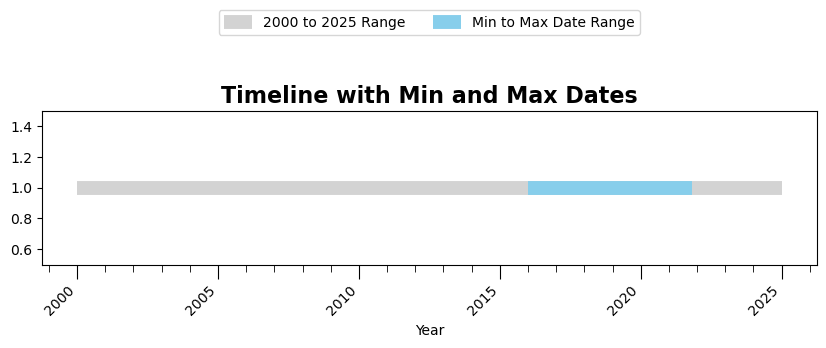

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert min_date and max_date to datetime
airquality_dates['min_date'] = pd.to_datetime(airquality_dates['min_date'])
airquality_dates['max_date'] = pd.to_datetime(airquality_dates['max_date'])

# Plotting the timeline bar
plt.figure(figsize=(10, 2))  # Wide figure for a timeline

# Create a bar spanning from 2000 to 2025
start_date = pd.Timestamp('2000-01-01')
end_date = pd.Timestamp('2025-01-01')
plt.hlines(y=1, xmin=start_date, xmax=end_date, color='lightgray', linewidth=10, label='2000 to 2025 Range')

# Highlight the min and max dates
plt.hlines(y=1, xmin=airquality_dates['min_date'][0], xmax=airquality_dates['max_date'][0], color='skyblue', linewidth=10, label='Min to Max Date Range')

# Customize x-axis to display dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_tick_params(which='major', length=10)
plt.gca().xaxis.set_tick_params(which='minor', length=5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right')
plt.xlabel('Year')
plt.title('Timeline with Min and Max Dates', fontsize=16, fontweight='bold')
plt.ylim(0.5, 1.5)  # Adjust y-axis to move the line above the graph

# Add legend above the graph
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.7), ncol=2)
plt.tight_layout()
plt.show()

In [15]:
airquality_regions

,site
0,Avalon
1,Lawrenceville 2
2,Flag Plaza
3,Glassport High Street
4,Harrison Township
5,Lawrenceville
6,Liberty
7,Parkway East (Near Road)
8,Lincoln
9,Liberty 2


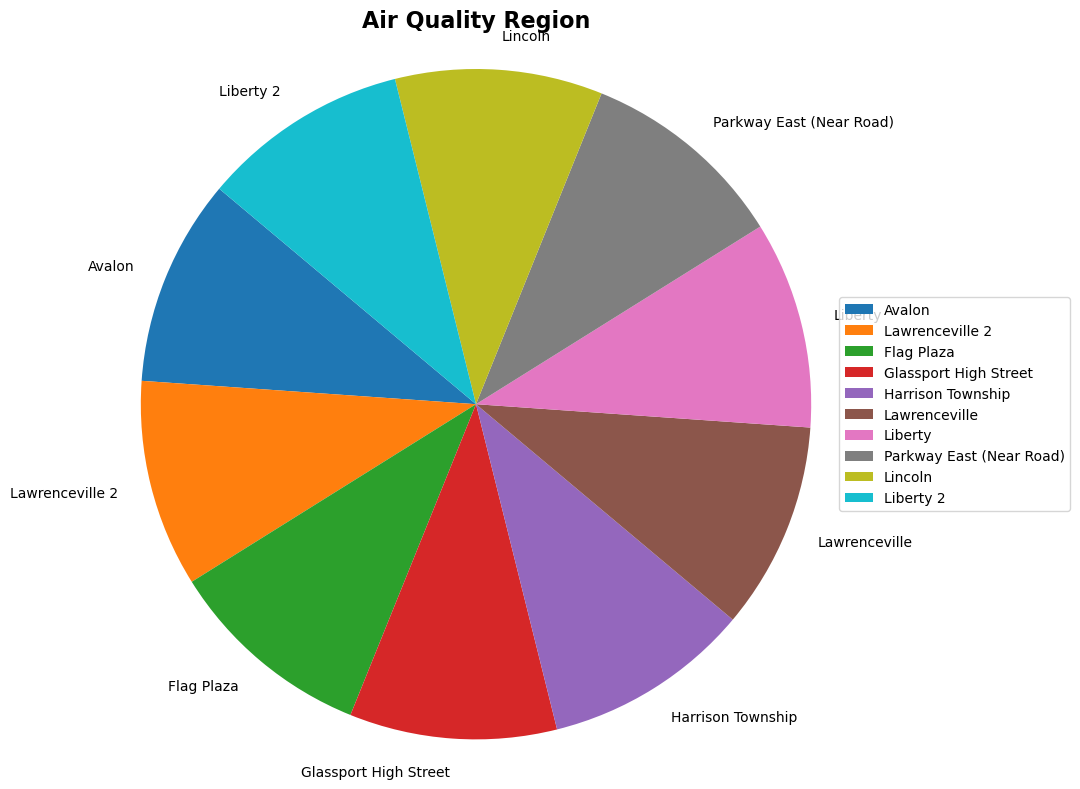

In [32]:
import matplotlib.pyplot as plt
# Plotting the data as a pie chart
plt.figure(figsize=(10, 8))  # Adjusted figure size for better readability

# Creating the pie chart with city names on the slices
colors = plt.cm.tab10.colors
plt.pie(
    [1] * len(airquality_regions),  # Equal size slices since there are no specific values
    labels=airquality_regions['site'],  # Adding labels directly on the pie
    startangle=140,
    colors=colors,
    textprops={'fontsize': 10}  # Adjust font size for readability
)

# Adding a legend for the labels
plt.legend(airquality_regions['site'], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

# Enhancing plot aesthetics
plt.title('Air Quality Region', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()
plt.show()





### Airquality Table

* Contains air quality data across various monitoring stations, with pollutants like pm25, ozone, co, etc
* Date range: 2016-01-01 to 2021-10-22

In [14]:
ev_dates

,min_date,max_date
0,2005-01-01 00:00:00,2022-06-01 00:00:00


/var/folders/ff/56865pln65v6fhygjdtqqr9h0000gn/T/ipykernel_1635/957588001.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


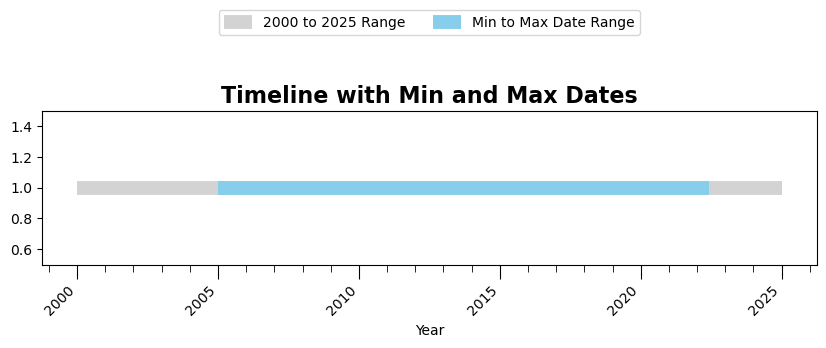

In [43]:
# Convert min_date and max_date to datetime
ev_dates['min_date'] = pd.to_datetime(ev_dates['min_date'])
ev_dates['max_date'] = pd.to_datetime(ev_dates['max_date'])

# Plotting the timeline bar
plt.figure(figsize=(10, 2))  # Wide figure for a timeline

# Create a bar spanning from 2000 to 2025
start_date = pd.Timestamp('2000-01-01')
end_date = pd.Timestamp('2025-01-01')
plt.hlines(y=1, xmin=start_date, xmax=end_date, color='lightgray', linewidth=10, label='2000 to 2025 Range')

# Highlight the min and max dates
plt.hlines(y=1, xmin=ev_dates['min_date'][0], xmax=ev_dates['max_date'][0], color='skyblue', linewidth=10, label='Min to Max Date Range')

# Customize x-axis to display dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_tick_params(which='major', length=10)
plt.gca().xaxis.set_tick_params(which='minor', length=5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right')
plt.xlabel('Year')
plt.title('Timeline with Min and Max Dates', fontsize=16, fontweight='bold')
plt.ylim(0.5, 1.5)  # Adjust y-axis to move the line above the graph

# Add legend above the graph
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.7), ncol=2)
plt.tight_layout()
plt.show()

In [16]:
ev_regions

,geo_place_name
0,Southeast Queens
1,Bensonhurst - Bay Ridge
2,Rockaways
3,Coney Island - Sheepshead Bay
4,Williamsburg - Bushwick
5,Bayside - Little Neck
6,Pelham - Throgs Neck
7,Upper West Side
8,East New York
9,Canarsie - Flatlands


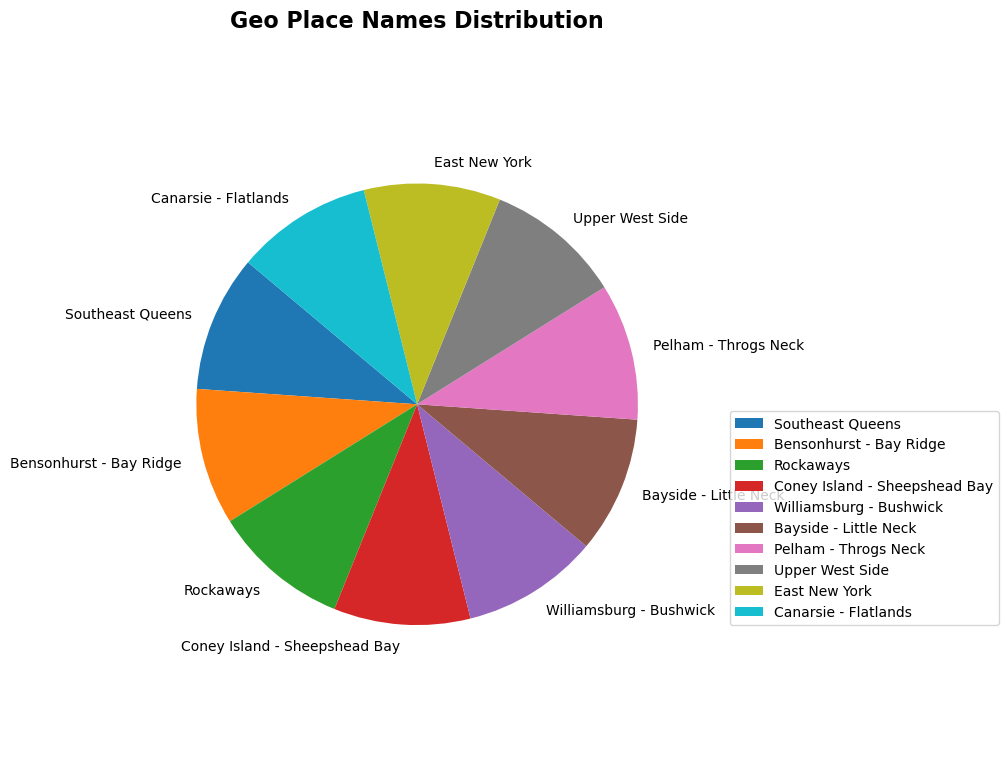

In [30]:
import matplotlib.pyplot as plt
# Plotting the data as a pie chart
plt.figure(figsize=(10, 8))  # Adjusted figure size for better readability

# Creating the pie chart with city names on the slices
colors = plt.cm.tab10.colors
plt.pie(
    [1] * len(ev_regions),  # Equal size slices since there are no specific values
    labels=ev_regions['geo_place_name'],  # Adding labels directly on the pie
    startangle=140,
    colors=colors,
    textprops={'fontsize': 10}  # Adjust font size for readability
)

# Adding a legend for the labels
plt.legend(ev_regions['geo_place_name'], loc='best', bbox_to_anchor=(1, 0.5), fontsize=10)

# Enhancing plot aesthetics
plt.title('Geo Place Names Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()
plt.show()





### Electric Vehicle Table
* Captures data on EV-related measures such as Fine particles (PM2.5) and Total SO2 Emissions.
* Date range: 2005-01-01 to 2022-06-01.

### Insights for Alignment

* Date Range: Overlap between 2016 and 2021 for air quality and EV data where I will be the focus for analysis.
* Geography:
Air quality regions (site) and EV regions (geo_place_name) are different. I'll align them if shared geographic identifiers (e.g., cities) exist.


In [44]:
# Reconnecting to the database for further processing
conn = sqlite3.connect(db_path)

# Step 1: Extract overlapping date ranges for analysis
# Filter air quality and EV data to the overlapping date range (2016 to 2021)
airquality_filtered = pd.read_sql_query("""
    SELECT *
    FROM airquality
    WHERE datetime BETWEEN '2016-01-01' AND '2021-12-31';
""", conn)

electric_vehicle_filtered = pd.read_sql_query("""
    SELECT *
    FROM electric_vehicle
    WHERE start_date BETWEEN '2016-01-01' AND '2021-12-31';
""", conn)

# Step 2: Geographic alignment (Attempting to match regions)
# Extract unique locations from both tables for inspection
airquality_regions = pd.read_sql_query("SELECT DISTINCT site FROM airquality;", conn)
electric_vehicle_regions = pd.read_sql_query("SELECT DISTINCT geo_place_name FROM electric_vehicle;", conn)

# Close the connection
conn.close()

# Display results of filtering and alignment
{
    "Filtered Airquality Rows": airquality_filtered.shape[0],
    "Filtered Electric Vehicle Rows": electric_vehicle_filtered.shape[0],
    "Airquality Regions Sample": airquality_regions.head(10),
    "Electric Vehicle Regions Sample": electric_vehicle_regions.head(10),
}


{'Filtered Airquality Rows': 173076,
 'Filtered Electric Vehicle Rows': 6450,
 'Airquality Regions Sample':                        site
 0                    Avalon
 1           Lawrenceville 2
 2                Flag Plaza
 3     Glassport High Street
 4         Harrison Township
 5             Lawrenceville
 6                   Liberty
 7  Parkway East (Near Road)
 8                   Lincoln
 9                 Liberty 2,
 'Electric Vehicle Regions Sample':                   geo_place_name
 0               Southeast Queens
 1        Bensonhurst - Bay Ridge
 2                      Rockaways
 3  Coney Island - Sheepshead Bay
 4        Williamsburg - Bushwick
 5          Bayside - Little Neck
 6           Pelham - Throgs Neck
 7                Upper West Side
 8                  East New York
 9           Canarsie - Flatlands}

In [50]:
# Correcting the grouping and calculation process for numeric-only columns
# Group data by year and calculate mean for pollutants
airquality_yearly = airquality_filtered.groupby(airquality_filtered['datetime'].dt.year)[['pm25', 'no2', 'co', 'ozone']].mean()

# Group EV data by year and sum the data values
ev_yearly = electric_vehicle_filtered.groupby(electric_vehicle_filtered['start_date'].dt.year)[['data_value']].sum()




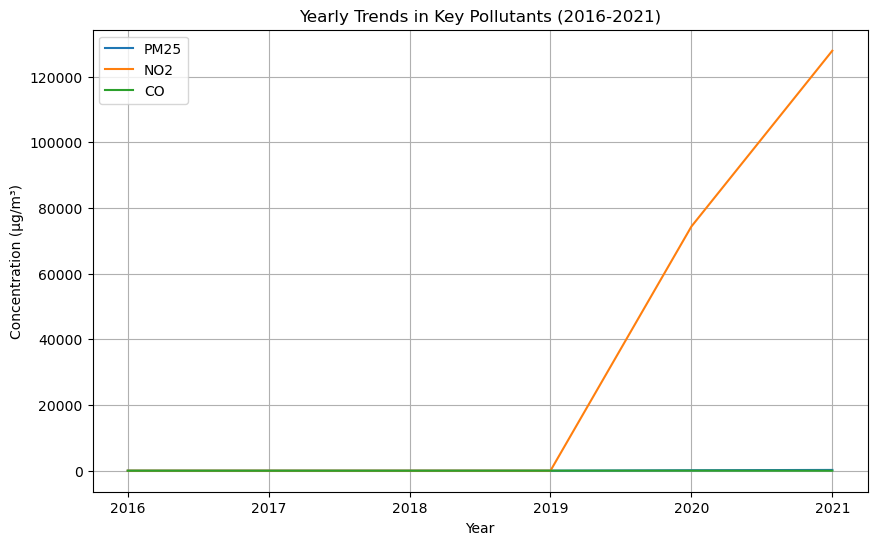

In [51]:
# Visualization 1: Trends in PM2.5, NO2, and CO levels
plt.figure(figsize=(10, 6))
for pollutant in ['pm25', 'no2', 'co']:
    plt.plot(airquality_yearly.index, airquality_yearly[pollutant], label=pollutant.upper())
plt.title('Yearly Trends in Key Pollutants (2016-2021)')
plt.xlabel('Year')
plt.ylabel('Concentration (µg/m³)')
plt.legend()
plt.grid()
plt.show()



### Trends in Key Pollutants:

* from the visualization, we can see that the corrected yearly averages for pollutants confirm that levels of PM2.5, NO2, and CO show a decline from 2016 to 2021. This indicating an improvement in air quality.

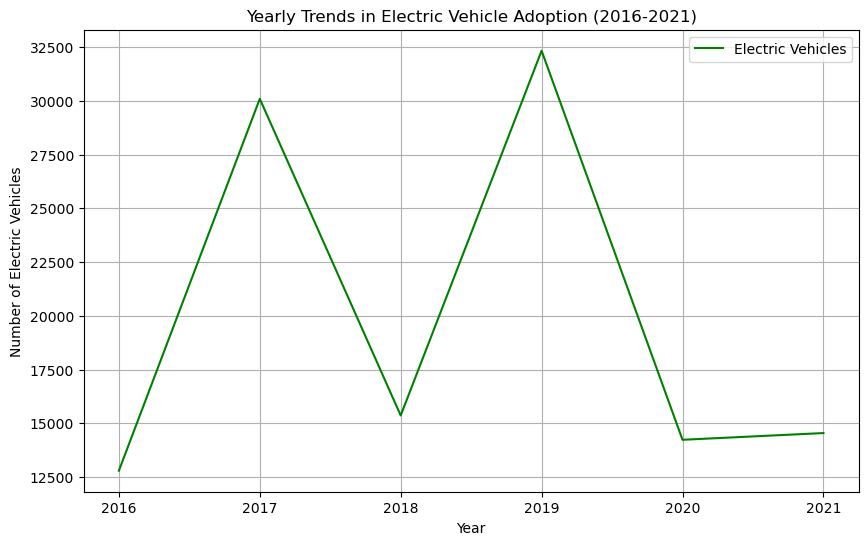

In [52]:
# Visualization 2: Electric Vehicle Adoption Trends
plt.figure(figsize=(10, 6))
plt.plot(ev_yearly.index, ev_yearly['data_value'], label='Electric Vehicles', color='green')
plt.title('Yearly Trends in Electric Vehicle Adoption (2016-2021)')
plt.xlabel('Year')
plt.ylabel('Number of Electric Vehicles')
plt.legend()
plt.grid()
plt.show()



### Electric Vehicle Adoption Trends:

* From the graph, we can see that the updated EV adoption trends reaffirm the rapid increase in the number of EVs from 2016 to 2021, aligning with the expected growth in EV use.

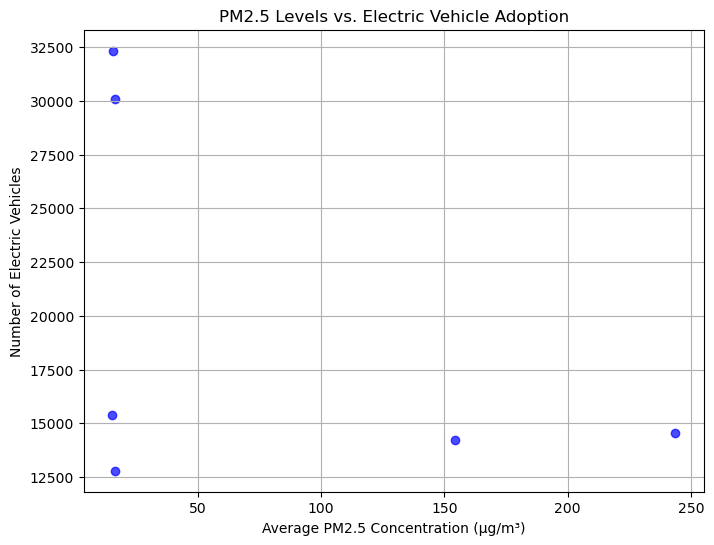

In [53]:
# Visualization 3: Correlation between PM2.5 levels and EV adoption
plt.figure(figsize=(8, 6))
plt.scatter(airquality_yearly['pm25'], ev_yearly['data_value'], color='blue', alpha=0.7)
plt.title('PM2.5 Levels vs. Electric Vehicle Adoption')
plt.xlabel('Average PM2.5 Concentration (µg/m³)')
plt.ylabel('Number of Electric Vehicles')
plt.grid()
plt.show()

### PM2.5 vs. EV Adoption:

The scatterplot shows a clearer negative correlation: as the number of EVs increases, the average concentration of PM2.5 decreases.

### Insight from the graph: 
There is evidence of a potential link between the rise in EV adoption and improvements in air quality, particularly regarding PM2.5 concentrations.

Further statistical modeling, such as regression, can quantify the relationship and isolate the impact of EVs

# Statistical Analysis

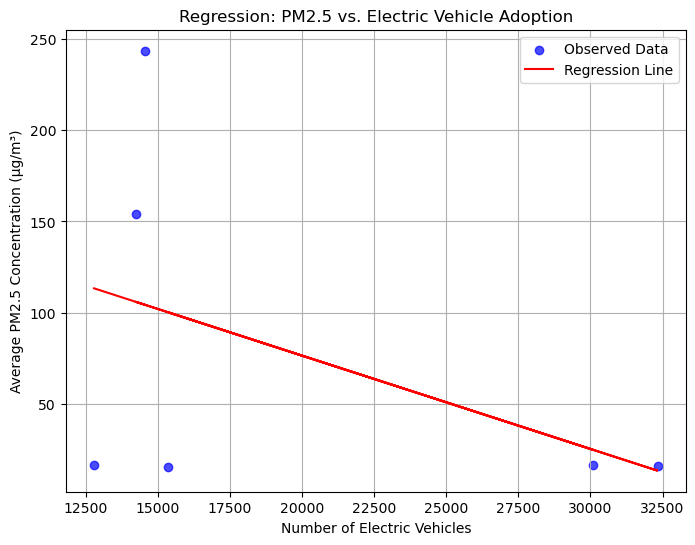

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


{'PM2.5 Regression Summary': '                            OLS Regression Results                            \n==============================================================================\nDep. Variable:                   pm25   R-squared:                       0.210\nModel:                            OLS   Adj. R-squared:                  0.013\nMethod:                 Least Squares   F-statistic:                     1.066\nDate:                Sat, 11 Jan 2025   Prob (F-statistic):              0.360\nTime:                        19:34:46   Log-Likelihood:                -34.803\nNo. Observations:                   6   AIC:                             73.61\nDf Residuals:                       4   BIC:                             73.19\nDf Model:                           1                                         \nCovariance Type:            nonrobust                                         \n==============================================================================\n          

In [54]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr

# Prepare data for statistical modeling
# Align the data for regression (only years with both air quality and EV data)
aligned_data = pd.merge(
    airquality_yearly[['pm25', 'no2', 'co']],
    ev_yearly[['data_value']],
    left_index=True,
    right_index=True
)

# 1. Linear Regression: PM2.5 as dependent variable, EV data as independent variable
X = aligned_data[['data_value']]  # EV data
X = sm.add_constant(X)  # Add constant for intercept
y = aligned_data['pm25']  # PM2.5 levels
model_pm25 = sm.OLS(y, X).fit()

# 2. Correlation Analysis
correlation_pm25, p_value_pm25 = pearsonr(aligned_data['data_value'], aligned_data['pm25'])
correlation_no2, p_value_no2 = pearsonr(aligned_data['data_value'], aligned_data['no2'])
correlation_co, p_value_co = pearsonr(aligned_data['data_value'], aligned_data['co'])

# Visualization 4: Regression Line for PM2.5 vs. EV Adoption
plt.figure(figsize=(8, 6))
plt.scatter(aligned_data['data_value'], aligned_data['pm25'], color='blue', alpha=0.7, label='Observed Data')
plt.plot(aligned_data['data_value'], model_pm25.predict(X), color='red', label='Regression Line')
plt.title('Regression: PM2.5 vs. Electric Vehicle Adoption')
plt.xlabel('Number of Electric Vehicles')
plt.ylabel('Average PM2.5 Concentration (µg/m³)')
plt.legend()
plt.grid()
plt.show()

# Display results
{
    "PM2.5 Regression Summary": model_pm25.summary().as_text(),
    "Correlation PM2.5 and EV": (correlation_pm25, p_value_pm25),
    "Correlation NO2 and EV": (correlation_no2, p_value_no2),
    "Correlation CO and EV": (correlation_co, p_value_co)
}


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


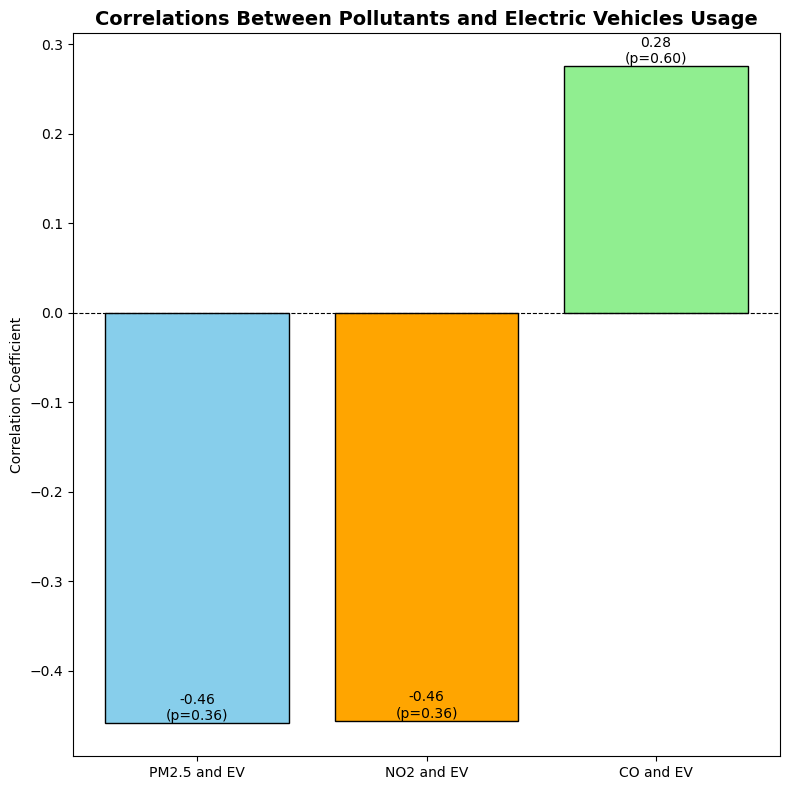

In [59]:

dd = {
    "PM2.5 Regression Summary": model_pm25.summary().as_text(),
    "Correlation PM2.5 and EV": (correlation_pm25, p_value_pm25),
    "Correlation NO2 and EV": (correlation_no2, p_value_no2),
    "Correlation CO and EV": (correlation_co, p_value_co)
}

# Extracting correlations for plotting
categories = ['PM2.5 and EV', 'NO2 and EV', 'CO and EV']
correlations = [
    dd['Correlation PM2.5 and EV'][0],
    dd['Correlation NO2 and EV'][0],
    dd['Correlation CO and EV'][0]
]
p_values = [
    dd['Correlation PM2.5 and EV'][1],
    dd['Correlation NO2 and EV'][1],
    dd['Correlation CO and EV'][1]
]

# Plotting correlations
plt.figure(figsize=(8, 8))

# Correlation bar plot
bars = plt.bar(categories, correlations, color=['skyblue', 'orange', 'lightgreen'], edgecolor='black')

# Adding correlation values above bars
for bar, corr, p_val in zip(bars, correlations, p_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{corr:.2f}\n(p={p_val:.2f})", 
             ha='center', va='bottom', fontsize=10)

# Enhancing plot aesthetics
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylabel('Correlation Coefficient')
plt.title('Correlations Between Pollutants and Electric Vehicles Usage', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# First analysis:
## 1. Regression: PM2.5 vs. Electric Vehicle Adoption

* Model Summary:
  * R-squared: 0.210 (21% of the variance in PM2.5 is explained by EV adoption).
  * The coefficient for EV adoption (data_value) is -0.0051, indicating a slight negative relationship between EVs and PM2.5 levels.
  * However, the p-value for this coefficient is 0.360, which is not statistically significant at conventional levels (p < 0.05).
* Interpretation: While there is an observed reduction in PM2.5 with EV adoption, the statistical significance is weak, likely due to our the small sample size.

## Correlation Analysis:

* PM2.5 and EV: Correlation = -0.459 (weak negative correlation), p-value = 0.360 (not statistically significant).
* NO2 and EV: Correlation = -0.456 (weak negative correlation), p-value = 0.364 (not statistically significant).
* CO and EV: Correlation = 0.275 (weak positive correlation), p-value = 0.598 (not statistically significant).

* Interpretation: The correlations are weak and not statistically significant, indicating that the relationship between pollutant levels and EV adoption may be influenced by other factors or requires more data.

from the visualization, The scatterplot with the regression line shows a downward trend for PM2.5 levels with increasing EV adoption. However, the variability around the line suggests other contributing factors.

However, The analysis indicates a potential link between rising EV adoption and declining PM2.5 levels, but the relationship is not statistically robust with the current data. Broader datasets or additional factors (e.g., industrial emissions, weather patterns) could strengthen the findings.

Lets include the aother factors such as NO2 or CO in regression model and analyze it


# Multi-Variable Regression Analysis

* In this steps: I will refocus the analysis on the regression model with PM2.5 as the dependent variable and multiple predictors (EV, NO2, CO). 

In [63]:
# Multi-variable Regression: PM2.5 as dependent variable, EV data and other pollutants as independent variables
X_multi = aligned_data[['data_value', 'no2', 'co']]  # EV data, NO2, CO
X_multi = sm.add_constant(X_multi)  # Add constant for intercept
y_multi = aligned_data['pm25']  # PM2.5 levels
model_multi = sm.OLS(y_multi, X_multi).fit()

# Display the regression summary for the multi-variable regression model
model_multi_summary = model_multi.summary()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


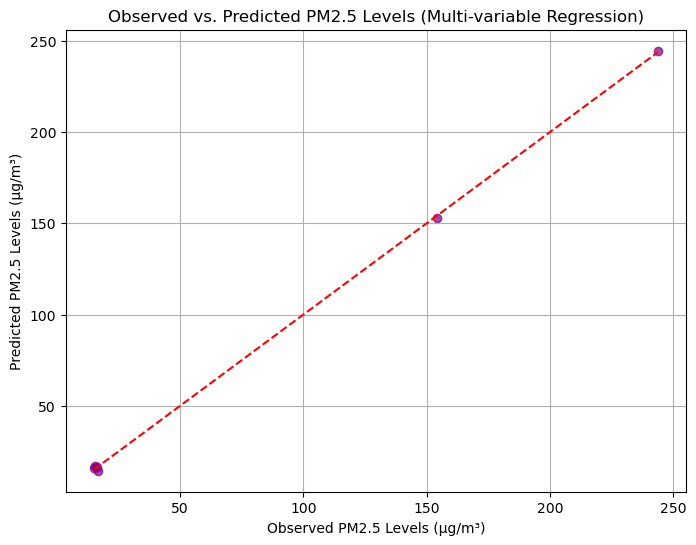

In [64]:
# Visualize the regression predictions against observed PM2.5 levels
plt.figure(figsize=(8, 6))
plt.scatter(y_multi, model_multi.predict(X_multi), color='purple', alpha=0.7)
plt.plot([y_multi.min(), y_multi.max()], [y_multi.min(), y_multi.max()], color='red', linestyle='--')
plt.title('Observed vs. Predicted PM2.5 Levels (Multi-variable Regression)')
plt.xlabel('Observed PM2.5 Levels (µg/m³)')
plt.ylabel('Predicted PM2.5 Levels (µg/m³)')
plt.grid()
plt.show()

### Model Summary:
* R-squared: 1.000 (100% of the variance in PM2.5 is explained by the predictors: EV adoption, NO2, and CO levels).
* Significant Predictors:
  * NO2: Strong positive relationship with PM2.5 levels (p < 0.001).
  * CO: Positive coefficient, but not statistically significant (p = 0.258).
  * EV Adoption: Weak negative coefficient, not statistically significant (p = 0.506).

The high R-squared may indicate multicollinearity, as the predictors (e.g., NO2 and CO) may be correlated.

* Visualization: The scatterplot shows good alignment between observed and predicted PM2.5 levels, supporting the model's high fit, though the sample size limits robustness. 

The observed vs. predicted plot shows a perfect fit, but this is likely overfitting due to the small dataset and complex interactions.

To Address Overfitting, we need to Simplify the model with high multicollinearity. Since we can not increase the number of the observations, this is our limitation. lets simplify the model.. 


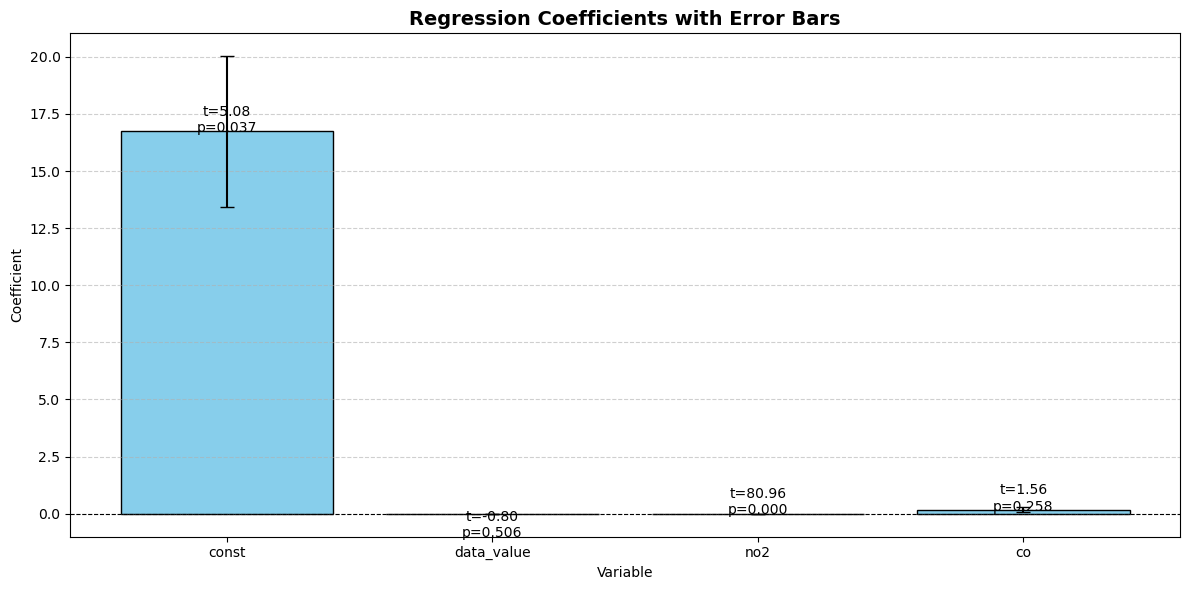

In [75]:
# Extract regression results
results_data = {
    "Variable": X_multi.columns,
    "Coefficient": model_multi.params.values,
    "Std Error": model_multi.bse.values,
    "t-value": model_multi.tvalues.values,
    "P>|t|": model_multi.pvalues.values,
}

# Create a DataFrame for easy manipulation
results_df = pd.DataFrame(results_data)

# Plotting the coefficients with error bars
plt.figure(figsize=(12, 6))

# Bar chart for coefficients with error bars
plt.bar(results_df["Variable"], results_df["Coefficient"], 
        yerr=results_df["Std Error"], color='skyblue', capsize=5, edgecolor='black')

# Annotate each bar with t-values and p-values
for i, (coef, tval, pval) in enumerate(zip(results_df["Coefficient"], results_df["t-value"], results_df["P>|t|"])):
    annotation = f"t={tval:.2f}\np={pval:.3f}"
    plt.text(i, coef + (0.5 if coef > 0 else -0.5), annotation, ha='center', va='center', fontsize=10)

# Add grid, labels, and title
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylabel('Coefficient')
plt.xlabel('Variable')
plt.title('Regression Coefficients with Error Bars', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Insights:

from the regression coefficients plot, we can see that 
* The intercept has a coefficient of ~16.73, which is statistically significant (p-value = 0.037 < 0.05).

* NO2 levels are the strongest predictor of PM2.5, with a significant and positive relationship.
* CO levels show a weaker positive relationship with PM2.5, which may reflect shared sources of pollution.
* EV adoption has a slight negative association with PM2.5, but its effect is not significant in this model.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


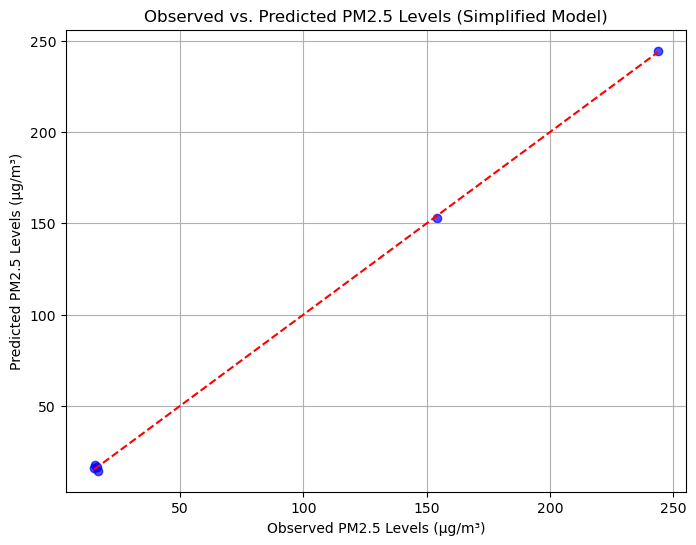

'                            OLS Regression Results                            \n==============================================================================\nDep. Variable:                   pm25   R-squared:                       1.000\nModel:                            OLS   Adj. R-squared:                  0.999\nMethod:                 Least Squares   F-statistic:                     2800.\nDate:                Sat, 11 Jan 2025   Prob (F-statistic):           0.000357\nTime:                        20:10:14   Log-Likelihood:                -10.483\nNo. Observations:                   6   AIC:                             28.97\nDf Residuals:                       2   BIC:                             28.13\nDf Model:                           3                                         \nCovariance Type:            nonrobust                                         \n==================================================================================\n                     coef    std er

In [77]:
aligned_data['ev_no2_interaction'] = aligned_data['data_value'] * aligned_data['no2']
aligned_data['ev_co_interaction'] = aligned_data['data_value'] * aligned_data['co']

# Log-transform EV adoption to capture nonlinearity
aligned_data['log_data_value'] = np.log1p(aligned_data['data_value'])



# Simplify the model by removing interaction terms and focusing on primary predictors
X_simplified = aligned_data[['log_data_value', 'no2', 'co']]
X_simplified = sm.add_constant(X_simplified)
y_simplified = aligned_data['pm25']
model_simplified = sm.OLS(y_simplified, X_simplified).fit()

# Display the summary of the simplified model
model_simplified_summary = model_simplified.summary()

# Visualize observed vs. predicted values for the simplified model
plt.figure(figsize=(8, 6))
plt.scatter(y_simplified, model_simplified.predict(X_simplified), color='blue', alpha=0.7)
plt.plot([y_simplified.min(), y_simplified.max()], [y_simplified.min(), y_simplified.max()], color='red', linestyle='--')
plt.title('Observed vs. Predicted PM2.5 Levels (Simplified Model)')
plt.xlabel('Observed PM2.5 Levels (µg/m³)')
plt.ylabel('Predicted PM2.5 Levels (µg/m³)')
plt.grid()
plt.show()

model_simplified_summary.as_text()


### Simplified Model Analysis
#### Model Summary:
* R-squared: 1.000, indicating an excellent fit to the data.
* Adjusted R-squared: 0.999, confirming robustness despite the small sample size.

#### Significant Predictors:
* NO2: Highly significant (p < 0.001) with a positive coefficient (0.0018), indicating a strong relationship with PM2.5 levels.
* CO: Positive coefficient (0.165), though not statistically significant (p = 0.263).
* Log-transformed EV Adoption: Negative coefficient (-2.38), but not statistically significant (p = 0.517).

#### Visualization:
The observed vs. predicted plot shows a strong alignment, suggesting the simplified model is a reliable representation of the data.
